# The Problem of Repeated Measurements
In psychological research, taking multiple measurements from a single subject is very common practice. Indeed, there are many advantages to doing so ...

## Repeated Measurement Designs
... also known as *longitudinal* designs. 

### Repeated Measurements Create Correlation

## Repeated Measurements Change the Variance Function
If we go back to our statistical modelling framework from PCHN63101, the key insight is that repeated measurements do *not* affect the mean function. Instead, repeated measurements change the *variance function*.

... The very act of multiplying these probabilities together to form the likelihood is an *implicit* assumption of independence. Probabilities only multiply to produce a correct overall probability when they are indpendent. If they are not independent, the value produced will be *wrong*. 

## The Multivariate Normal Distribution
Given all the above, how do we move forward with conceptualising a repeated measurements design in terms of population distributions and sampling? The key insight comes from moving from a *univariate* distribution to a *multivariate* distribution. Here, we will use the example of a multivariate normal distribution because it is easiest to conceptualise.

$$
\begin{bmatrix}
    y_{i1} \\
    y_{i2}
\end{bmatrix}
\sim\mathcal{N}\left(
\begin{bmatrix}
    \mu_{1} \\
    \mu_{2}
\end{bmatrix}, 
\begin{bmatrix}
    \sigma^{2}_{1} & \sigma_{12}  \\
    \sigma_{21}    & \sigma^{2}_{2}
\end{bmatrix}
\right)
$$

So, everytime we draw data from this multivariate distribution, we actually get *two* values. The first has a population mean of $\mu_{1}$ and a variance of $\sigma^{2}_{1}$. The second has a population mean of $\mu_{2}$ and a variance of $\sigma^{2}_{2}$. Most importantly, the two values will be *correlated* by a factor of $\sigma_{12}$. If $\sigma_{12} = 0$ then this will be no different to drawing two values from a univariate normal distribution, as the values will be uncorrelated. The value of the first draw will not influence the value of the second draw in any way. However, if $|\sigma_{12}| > 0$ then the two draws will be related, with their values becoming more and more similar the larger the correlation becomes.

### Conceptualising Multiple Subjects

$$
\begin{bmatrix}
    y_{11} \\
    y_{12} \\
    y_{21} \\
    y_{22} \\
    y_{31} \\
    y_{32} \\
\end{bmatrix}
\sim\mathcal{N}\left(
\begin{bmatrix}
    \mu_{1} \\
    \mu_{2} \\
    \mu_{1} \\
    \mu_{2} \\
    \mu_{1} \\
    \mu_{2} \\
\end{bmatrix}, 
\begin{bmatrix}
    \sigma^{2}_{1} & \sigma_{12} & 0 & 0 & 0 & 0  \\
    \sigma_{21}    & \sigma^{2}_{2} & 0 & 0 & 0 & 0 \\
    0 & 0 & \sigma^{2}_{1} & \sigma_{12} & 0 & 0 \\
    0 & 0 & \sigma_{21}    & \sigma^{2}_{2} & 0 & 0  \\
    0 & 0 & 0 & 0 & \sigma^{2}_{1} & \sigma_{12} \\
    0 & 0 & 0 & 0 & \sigma_{21}    & \sigma^{2}_{2} \\
\end{bmatrix}
\right)
$$

This is a 6-dimensional normal distribution, so we would struggly to visualise this in any meaningful way. However, as mentioned last semester, dimensions are just a mathematical tool for keeping track of information. We do not *have* to be able to visualise them in order for this to be useful or make sense. The more important element here is the *structure*. 

As we can see, each subject is given by the *first* index of $y$. So, we have two measurements from subject 1, two measurements from subject 2 and two measurements from subject 3. We conceptualise this dataset as a single draw from a 6-dimensional normal distribution. The mean vector tells us that the population means for each condition are identical across subjects, so our interest is estimating $\mu_{1}$ and $\mu_{2}$. If the data came from 6 different subjects, this would be no different from assuming $y_{i1} \sim \mathcal{N}(\mu_{1}, \sigma^{2}_{1})$ and $y_{i2} \sim \mathcal{N}(\mu_{2}, \sigma^{2}_{2})$. However, because these are *repeated measurements*, the important aspect here is the correlation structure embedded in the *variance-covariance* matrix. This has a *block-diagonal* structure, which implies that there is *no correlation* between measurements from *different* subjects. This seems fair, as it is usually unlikely that separate subjects would affect each other. However, *within* each subject we assume a separate variance for each condition ($\sigma^{2}_{1}$, $\sigma^{2}_{2}$) and some *non-zero* covariance ($\sigma_{12} = \sigma_{21}$) that captures how correlated the responses are from an individual subject.

### Multivariate Normal Simulations in `R`
We can simulate drawing data from a multivariate normal disribution in `R` by using the `mvrnorm()` function from the `MASS` package. To do so, we provide a *vector* of means and a variance-covariance matrix. For instance, drawing a single-subject from an experiment with 2 repeated measurement conditions can be simulated using

In [1]:
library(MASS)
set.seed(666)

var   <- 1                                  # Variance of condition 1 & 2
rho   <- 0.8                                # Correlation between conditions 1 & 2
cov   <- rho*sqrt(var)*sqrt(var)            # Covariance between conditions 1 & 2

Mu    <- c(2,3)                             # Mean vector
Sigma <- matrix(c(var,cov,
                  cov,var), nrow=2, ncol=2) # Variance-covariance matrix

y <- mvrnorm(n=1, mu=Mu, Sigma=Sigma)
print(y)

[1] 2.077659 4.351648


So we can see that we get *two* values back whenever we sample from this distribution. These represent a random draw from condition 1 and a random draw from condition 2, with some degree of correlation. Notice that `mvrnorm()` returns the random draws as a *row* of values, rather than a column (as we showed earlier). This will only make a difference to way the values are arranged, but the interpretation remains the same. The mean vector is given by

In [2]:
print(Mu)

[1] 2 3


and the variance-covariance matrix is given by

In [3]:
print(Sigma)

     [,1] [,2]
[1,]  1.0  0.8
[2,]  0.8  1.0


We can repeat this again for *multiple* subjects to see the full conceptualisation of this experiment. If we had $n=15$ then we can simulate our simple repeated measurements experiment using

In [4]:
y <- mvrnorm(n=15, mu=Mu, Sigma=Sigma)
print(y)

            [,1]     [,2]
 [1,]  1.5540228 2.772157
 [2,]  4.1082767 4.739901
 [3,] -0.3517207 1.145497
 [4,]  2.9383388 3.500617
 [5,]  1.1349551 1.386733
 [6,]  0.8374173 2.639909
 [7,]  0.3985685 1.200894
 [8,]  1.9504570 2.969792
 [9,]  4.5084460 4.570973
[10,]  0.6768891 0.964334
[11,]  3.3780586 3.262506
[12,]  0.7041465 1.032087
[13,]  2.5519364 2.702549
[14,]  1.6893139 3.166815
[15,]  3.0171120 3.611399


So, now we have 15 measurements from condition 1 and 15 measurements from conditon 2. These are arranged per-subject, so the first row is the two measurements from subject 1, the second row is the two measurments from subject 2 and so on. Importantly, the two columns are *correlated*, which we can see using

In [5]:
print(cor(y[,1],y[,2]))

[1] 0.9144557


or by plotting the columns against each other

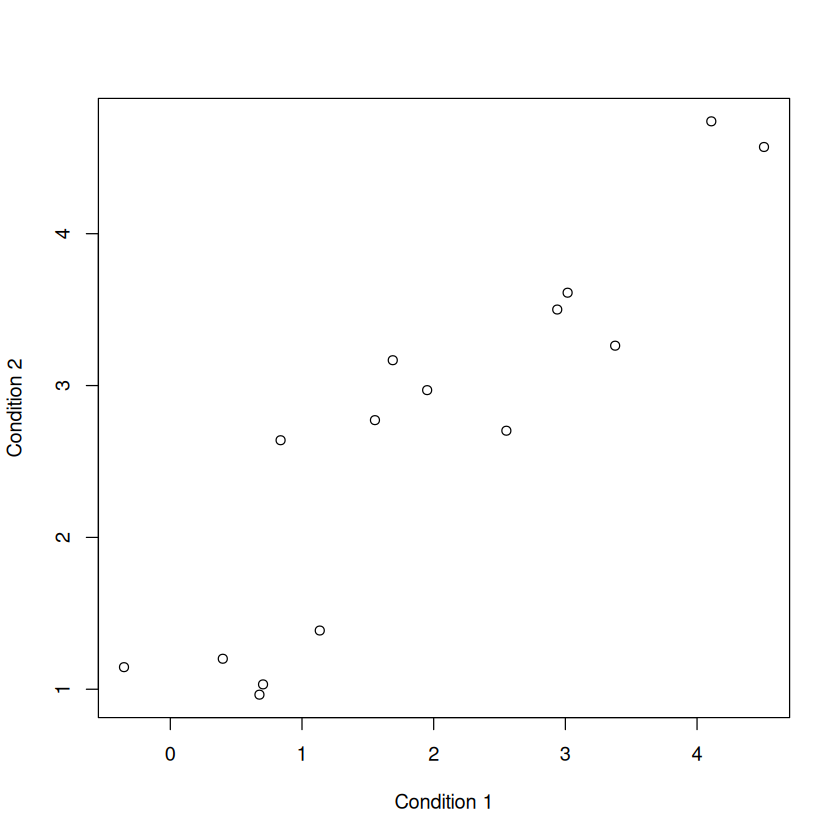

In [6]:
plot(y[,1], y[,2], xlab="Condition 1", ylab="Condition 2")

We can now see how the multivariate normal distribution serves as a *model* of repeated measurements. To put this into our more general framework, this is a more complex *variance function* that allows for correlation between the measurements.

## Correlation Affects the Standard Errors
Given everything above, what are the implications for our statistical model when there is correlation between measurements? As we have discussed, nothing about the *mean function* changes. So if we are only interested in estimating effects as defined within the mean function, nothing changes. This means that regression slopes, cell means and mean differences remain unchanged. However, what *does* change is the *variance function*. The biggest practical implication of this is that *correlation changes the standard errors*. This means that our *uncertainty* is different under correlation. If we get this wrong, the standard errors will be wrong, the test statistical will be wrong, the confidence intervals will be wrong and the $p$-values will be wrong. In short, neglecting to model the correlational structure will make our *inference wrong*. In a more general sense, neglecting the correlational structure will lead to a poor model of the data-generating process, because correlation is a *fundamental* element of how the data came to be. If we ignore it, we can never hope to have an accurate picture of where our data came from. 

### Theory
The simplest demonstration of how correlation affects uncertainty comes directly from the properties of a random variable. It is a standard result in probability theory that the variance of the *difference* between two random variables ($y_{1}$ and $y_{2}$) is given by 

$$
\text{Var}\left(y_{1} - y_{2}\right) = \text{Var}\left(y_{1}\right) + \text{Var}\left(y_{2}\right) - 2\text{Cov}\left(y_{1},y_{2}\right).
$$

To understand this, consider the fact that subtracting two random variables produces a *new* random variable that captures their *difference*. This new random variable will also have a distribution. So what we are thinking above in the above equation is the *width* of the distribution of the *difference* between $y_{1}$ and $y_{2}$. What this is saying is that the width of this distribution is a function of the variances from the two individual distributions *and* their degree of correlation. If the correlation is *positive* the variance will shrink, if the correlation is *negative* the variance will *grow*. Either way, our uncertainty around the difference between these two random variables *depends* upon their degree of correlation

### Simulation

To see this, we can run a simulation in `R`. First, we use the `mvrnorm()` function from the `MASS` package to simulate 1,000 realisations of two repeated measurements with a correlation of $\rho = 0.8$. To do this, we use the following sampling model:

$$
\begin{bmatrix}
    y_{i1} \\
    y_{i2} \\
\end{bmatrix}
\sim\mathcal{N}\left(
\begin{bmatrix}
    2 \\
    3 \\
\end{bmatrix},
\begin{bmatrix}
    1 & 0.8 \\
    0.8 & 1 \\
\end{bmatrix}
\right)
$$

We can then compare this to 1,000 realisations of two independent measurements with a correlation of $\rho = 0$. To do this, we use the following sampling model

$$
\begin{bmatrix}
    y_{i1} \\
    y_{i2} \\
\end{bmatrix}
\sim\mathcal{N}\left(
\begin{bmatrix}
    2 \\
    3 \\
\end{bmatrix},
\begin{bmatrix}
    1 & 0 \\
    0 & 1 \\
\end{bmatrix}
\right).
$$

The `R` code is

In [29]:
Sigma.dep <- matrix(c(var,cov,
                      cov,var), nrow=2, ncol=2)

Sigma.ind <- matrix(c(var,   0,
                        0, var), nrow=2, ncol=2)

y.dep <- mvrnorm(n=1000, mu=Mu, Sigma=Sigma.dep) # dependence
y.ind <- mvrnorm(n=1000, mu=Mu, Sigma=Sigma.ind) # independence

In both cases, we conceptualise the columns of `y.dep` and `y.ind` as two different conditions of an experiment. As such, our interest lies in the *difference* between the columns. As a final step, we subtract the columns and then compare the distributions of differences.

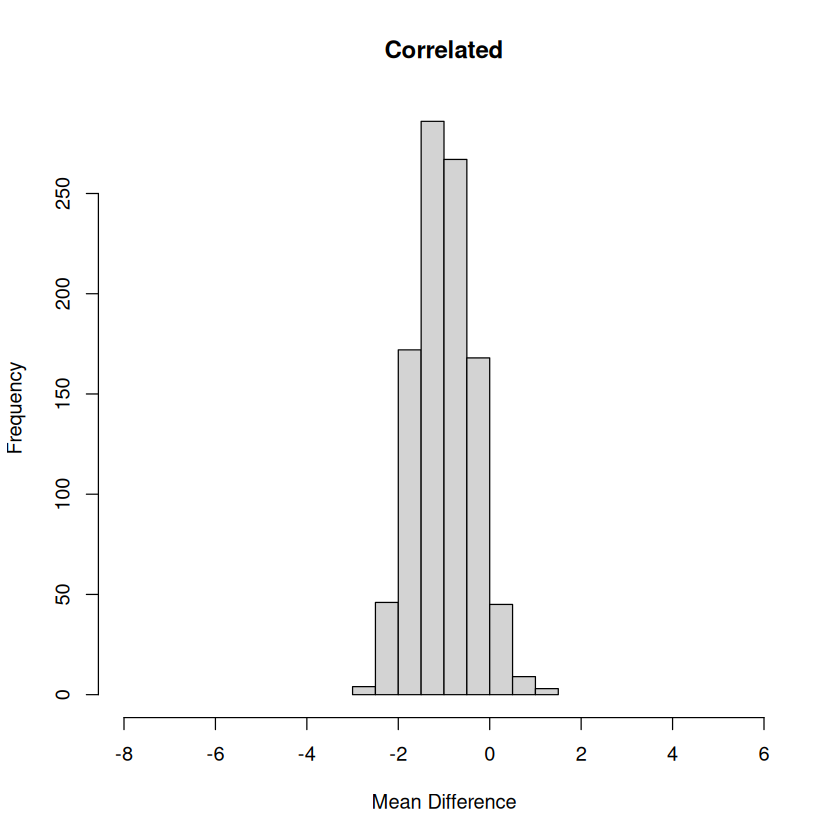

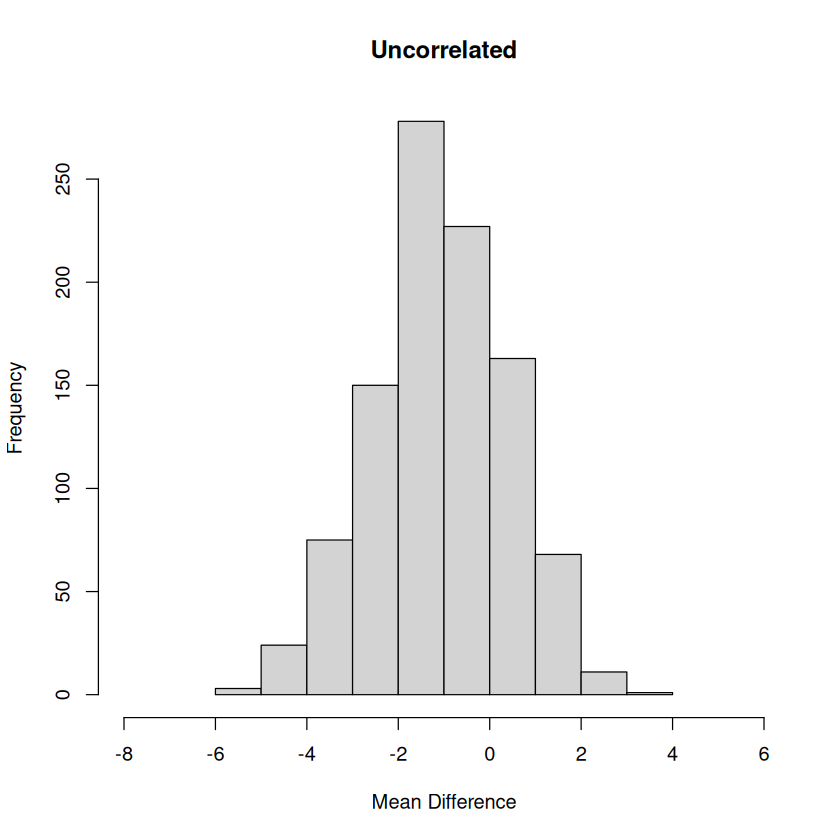

In [36]:
diff.dep <- y.dep[,1] - y.dep[,2]
diff.ind <- y.ind[,1] - y.ind[,2]

hist(diff.dep, xlim=c(-8,6), xlab='Mean Difference', main='Correlated')
hist(diff.ind, xlim=c(-8,6), xlab='Mean Difference', main='Uncorrelated')

Notice that the distribution of repeated measurement differences is much *narrower* than the distribution of independent differences. This is the theory in action. ... This is why there is a *power* advantage to repeated measurements. ... The variability of the difference is much smaller because the conditions are going to be *more similar* when they are correlated. As such, we do not expect wild differences between them. The two conditions should generally be very similar and thus their difference should be consistently smaller than in the independent case, where much larger differences are possible.

We can see how this will affect the $t$-statistic by calculating

## Take-home Message

```{admonition} Take Home Message
Dependence influences the magnitude of the standard errors when comparing correlated measurements. This has two important ramifications:

1. When designing an experiment, we can improve power by using repeated measurements, so long as the correlation is *positive*.
2. When analysing data, it is important that this correlation is taken into account so that the standard errors are accurate. Depending upon the nature of the dependency, they will either be *smaller* or *larger* than under independent conditions.


```

[^foot1]: For the purpose of this simulation, the fact that there is no mean difference does not matter. All this influences is what number the distribution of differences is centred-on.